In [1]:
import pandas as pd
import numpy as np
import os
import time
from collections import namedtuple
pd.set_option("display.max_rows",100)
%matplotlib inline

In [2]:
train_paths = {"mawiitrain":"dataset/preprocessed_train_data5.pkl"}
test_paths = {"mawiitest":"dataset/preprocessed_test4_data.pkl"}

class preprocess:
    
    def get_data(paths):
        
        for key, value in paths.items():
            sample_data = pd.read_pickle(value)
            x = sample_data.iloc[:,:-2]
            y = sample_data.iloc[:,-2:]
            yield key, x.values, y.values

In [3]:
import tensorflow as tf
from tensorflow.contrib.legacy_seq2seq.python.ops.seq2seq import basic_rnn_seq2seq
from tensorflow.contrib.rnn import RNNCell, LSTMCell, MultiRNNCell
from sklearn import model_selection as ms
from sklearn import metrics as me

c:\users\anusha\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
class network(object):
    
    input_dim = 4
    classes = 2
    hidden_encoder_dim = 4
    hidden_layers = 1
    latent_dim = 5

    hidden_decoder_dim = 4
    lam = 0.01
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x_input = tf.placeholder("float", shape=[None, 1, input_dim])
            self.y_input_ = tf.placeholder("float", shape=[None, 1, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
            self.x_list = tf.unstack(self.x_input, axis= 1)
            self.y_list_ = tf.unstack(self.y_input_, axis = 1)
            self.y_ = self.y_list_[0]
            
            #GO = tf.fill((tf.shape(self.x)[0], 1), 0.5)
            
            #y_with_GO = tf.stack([self.y_, GO])
            
        with tf.variable_scope("lstm"):
            multi_cell = MultiRNNCell([LSTMCell(input_dim) for i in range(hidden_layers)] )
            
            self.y, states = basic_rnn_seq2seq(self.x_list, self.y_list_, multi_cell)
            #self.y = tf.slice(self.y, [0, 0], [-1,2])
            
            #self.out = tf.squeeze(self.y)
            
            #self.y = tf.layers.dense(self.y[0], classes, activation = None)
            
            self.y = tf.slice(self.y[0], [0, 0], [-1,2])
            
        with tf.variable_scope("Loss"):
            
            self.regularized_loss = tf.losses.mean_squared_error(self.y_, self.y)
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()

In [5]:
import collections

class Train:    
    
    result = namedtuple("score", ['key', 'no_of_features','hidden_layers','train_score', 'test_score', 'quality_score', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0

    def train(epochs, net, h,f, lrs):
        batch_iterations = 1000
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_lstm_nsl_kdd-orig/hidden layers_{}_features count_{}".format(h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            
            
            for c, lr in enumerate(lrs):
                for epoch in range(1, (epochs+1)):
                    for key, x_train, y_train in preprocess.get_data(train_paths):
                        x_train, x_valid, y_train, y_valid, = ms.train_test_split(x_train, 
                                                                                  y_train, 
                                                                                  test_size=0.1)
                        batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                                   batch_iterations)

                        for i in batch_indices:

                            _, train_loss = sess.run([net.train_op, net.regularized_loss], #net.summary_op
                                                      feed_dict={net.x_input: x_train[i,np.newaxis,:], 
                                                                 net.y_input_: y_train[i,np.newaxis,:], 
                                                                 net.keep_prob:1, net.lr:lr})
                            #summary_writer_train.add_summary(summary_str, epoch)
                            if(train_loss > 1e9):
                                print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))


                        valid_accuracy,valid_loss = sess.run([net.tf_accuracy, net.regularized_loss], #net.summary_op 
                                                              feed_dict={net.x_input: x_valid[:,np.newaxis,:], 
                                                                         net.y_input_: y_valid[:,np.newaxis,:], 
                                                                         net.keep_prob:1, net.lr:lr})
                        #summary_writer_valid.add_summary(summary_str, epoch)

                        
                    end_time = time.perf_counter() 
                    for key, x_test, y_test in preprocess.get_data(test_paths):
                        accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                               net.pred, 
                                                                               net.actual, net.y], 
                                                                              feed_dict={net.x_input: x_test[:,np.newaxis,:], 
                                                                                         net.y_input_: y_test[:,np.newaxis,:], 
                                                                                         net.keep_prob:1, net.lr:lr})

                        quality_score = me.matthews_corrcoef(actual_value, pred_value)
                        recall = me.recall_score(actual_value, pred_value)
                        prec = me.precision_score(actual_value, pred_value)
                        accuracy = me.roc_auc_score(actual_value, pred_value)
                        
                        print("Key {} | Training Loss: {:.6f} | Train Accuracy: {:.6f} | Test Accuracy: {:.6f}, quality_score: {}, recall: {}, prec: {}".format(key, train_loss, valid_accuracy, accuracy, quality_score, recall, prec))

                        if accuracy > Train.best_acc_global:
                                    Train.best_acc_global = accuracy
                                    Train.pred_value = pred_value
                                    Train.actual_value = actual_value

                                    Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value, "Actual":actual_value})
                        Train.predictions.update({"{}_{}_{}".format(key,f,h):
                                                  (curr_pred, 
                                                   Train.result(key, f, h,valid_accuracy, accuracy, quality_score, end_time - start_time))})

In [6]:
import itertools

df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():

        global df_results
        global past_scores
        
        Train.predictions = {}
        Train.results = []
        
        features_arr = [1.5, 3, 4.5, 6] #[4, 8, 16, 32]
        hidden_layers_arr = [1, 3]

        epochs = [40]
        lrs = [1e-5] #[1e-2, 1e-2/2, 1e-2/4]

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)
            
        dict1 = {}
        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)
            
        Train.predictions = dict1
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)
        #temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/scores/tf_lstm_mawih4.pkl'):
            past_scores = df_results
        else:
            past_scores = pd.read_pickle("dataset/scores/tf_lstm_mawih4.pkl")

        past_scores.append(df_results).to_pickle("dataset/scores/tf_lstm_mawih4.pkl")

In [7]:
Hyperparameters.start_training()

Current Layer Attributes - epochs:40 hidden layers:1 features count:1.5
Key mawiitest | Training Loss: 0.708341 | Train Accuracy: 1.000000 | Test Accuracy: 0.999808, quality_score: 0.9997237141603467, recall: 1.0, prec: 0.9998308753889866
Key mawiitest | Training Loss: 0.664439 | Train Accuracy: 1.000000 | Test Accuracy: 0.999808, quality_score: 0.9997237141603467, recall: 1.0, prec: 0.9998308753889866
Key mawiitest | Training Loss: 0.702994 | Train Accuracy: 1.000000 | Test Accuracy: 0.999808, quality_score: 0.9997237141603467, recall: 1.0, prec: 0.9998308753889866
Key mawiitest | Training Loss: 0.652384 | Train Accuracy: 1.000000 | Test Accuracy: 0.999808, quality_score: 0.9997237141603467, recall: 1.0, prec: 0.9998308753889866
Key mawiitest | Training Loss: 0.587198 | Train Accuracy: 1.000000 | Test Accuracy: 0.999808, quality_score: 0.9997237141603467, recall: 1.0, prec: 0.9998308753889866
Key mawiitest | Training Loss: 0.540644 | Train Accuracy: 1.000000 | Test Accuracy: 0.999808,

Key mawiitest | Training Loss: 0.612653 | Train Accuracy: 0.760417 | Test Accuracy: 0.535583, quality_score: 0.2246793195265601, recall: 1.0, prec: 0.7093422284082456
Key mawiitest | Training Loss: 0.141671 | Train Accuracy: 0.796875 | Test Accuracy: 0.535199, quality_score: 0.22343867571514833, recall: 1.0, prec: 0.7091720448165831
Key mawiitest | Training Loss: 0.135098 | Train Accuracy: 0.744792 | Test Accuracy: 0.534624, quality_score: 0.2215658132165284, recall: 1.0, prec: 0.7089169224865695
Key mawiitest | Training Loss: 0.596455 | Train Accuracy: 0.768229 | Test Accuracy: 0.533052, quality_score: 0.21637101945061188, recall: 1.0, prec: 0.7082205237559
Key mawiitest | Training Loss: 0.362568 | Train Accuracy: 0.809896 | Test Accuracy: 0.530828, quality_score: 0.20881992365500388, recall: 1.0, prec: 0.7072377078597918
Key mawiitest | Training Loss: 0.314224 | Train Accuracy: 0.736979 | Test Accuracy: 0.530752, quality_score: 0.20855504576692493, recall: 1.0, prec: 0.70720386630619

Key mawiitest | Training Loss: 0.607681 | Train Accuracy: 0.218750 | Test Accuracy: 0.468812, quality_score: -0.1828807338718724, recall: 0.00625866910247302, prec: 0.1712962962962963
Key mawiitest | Training Loss: 0.579731 | Train Accuracy: 0.247396 | Test Accuracy: 0.468812, quality_score: -0.1828807338718724, recall: 0.00625866910247302, prec: 0.1712962962962963
Key mawiitest | Training Loss: 0.555824 | Train Accuracy: 0.255208 | Test Accuracy: 0.469080, quality_score: -0.18188197261962386, recall: 0.00625866910247302, prec: 0.1724137931034483
Key mawiitest | Training Loss: 0.575883 | Train Accuracy: 0.270833 | Test Accuracy: 0.469131, quality_score: -0.1813367019664299, recall: 0.006360161033864474, prec: 0.17472118959107807
Key mawiitest | Training Loss: 0.553695 | Train Accuracy: 0.247396 | Test Accuracy: 0.469361, quality_score: -0.1804761179387864, recall: 0.006360161033864474, prec: 0.17570093457943925
Key mawiitest | Training Loss: 0.553186 | Train Accuracy: 0.200521 | Test A

c:\users\anusha\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Key mawiitest | Training Loss: 0.438222 | Train Accuracy: 0.697917 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.400874 | Train Accuracy: 0.726562 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.408854 | Train Accuracy: 0.734375 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.383838 | Train Accuracy: 0.726562 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.393713 | Train Accuracy: 0.763021 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.367513 | Train Accuracy: 0.747396 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.377480 | Train Accuracy: 0.731771 | Test Accuracy: 0.50

Key mawiitest | Training Loss: 0.363512 | Train Accuracy: 0.726562 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.350465 | Train Accuracy: 0.755208 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.366608 | Train Accuracy: 0.700521 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.321058 | Train Accuracy: 0.812500 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.381265 | Train Accuracy: 0.736979 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.292104 | Train Accuracy: 0.700521 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.277727 | Train Accuracy: 0.731771 | Test Accuracy: 0.50

Key mawiitest | Training Loss: 0.342842 | Train Accuracy: 0.742188 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.341899 | Train Accuracy: 0.752604 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.231547 | Train Accuracy: 0.708333 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.228099 | Train Accuracy: 0.710938 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.110115 | Train Accuracy: 0.747396 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.226133 | Train Accuracy: 0.729167 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.226009 | Train Accuracy: 0.703125 | Test Accuracy: 0.50

Key mawiitest | Training Loss: 0.487460 | Train Accuracy: 0.726562 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.475731 | Train Accuracy: 0.716146 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.471312 | Train Accuracy: 0.770833 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.462806 | Train Accuracy: 0.731771 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.454149 | Train Accuracy: 0.752604 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.444707 | Train Accuracy: 0.750000 | Test Accuracy: 0.500000, quality_score: 0.0, recall: 1.0, prec: 0.6938895279231907
Key mawiitest | Training Loss: 0.435016 | Train Accuracy: 0.726562 | Test Accuracy: 0.50

In [8]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_lstm_mawih4.pkl")
df_results.to_pickle("dataset/tf_lstm_scores_mawih4.pkl")

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Positive", "\n False Negative \n Type II Error"],
             ["\n False Positive \n Type I Error", "\n True Negative"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False)

In [10]:
past_scores = pd.read_pickle("dataset/scores/tf_lstm_mawih4.pkl")

In [11]:
past_scores.sort_values(by='quality_score', ascending = False)

,key,no_of_features,hidden_layers,train_score,test_score,quality_score,time_taken
2,mawiitest,4.5,1,0.916667,0.866296,0.809499,43.033756
0,mawiitest,1.5,1,0.820312,0.646143,0.459666,37.430219
1,mawiitest,3.0,1,0.755208,0.535199,0.223439,41.726588
1,mawiitest,3.0,1,0.736979,0.510475,0.094544,177.134700
1,mawiitest,3.0,1,0.736979,0.510475,0.094544,177.134700
0,mawiitest,1.5,1,0.752604,0.500000,0.000000,124.654747
5,mawiitest,3.0,3,0.729167,0.500000,0.000000,250.763411
6,mawiitest,4.5,3,0.734375,0.500000,0.000000,85.027343
5,mawiitest,3.0,3,0.750000,0.500000,0.000000,56.901701
4,mawiitest,1.5,3,0.692708,0.500000,0.000000,64.577971


In [12]:
psg = past_scores.sort_values(by='quality_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
psg.first().sort_values(by='quality_score', ascending=False)

key  train_score  test_score  \
no_of_features hidden_layers                                       
4.5            1              mawiitest     0.916667    0.866296   
1.5            1              mawiitest     0.820312    0.646143   
3.0            1              mawiitest     0.755208    0.535199   
1.5            3              mawiitest     0.692708    0.500000   
3.0            3              mawiitest     0.729167    0.500000   
4.5            3              mawiitest     0.734375    0.500000   
6.0            1              mawiitest     0.747396    0.500000   
               3              mawiitest     0.742188    0.500000   

                              quality_score  time_taken  
no_of_features hidden_layers                             
4.5            1                   0.809499   43.033756  
1.5            1                   0.459666   37.430219  
3.0            1                   0.223439   41.726588  
1.5            3                   0.000000   64.577971  
3.0            3                   0.000000  250.763411  
4.5            3                   0.000000   85.027343  
6.0            1                   0.000000   38.926369  
               3                   0.000000  224.041596

In [13]:
Train.predictions = pd.read_pickle("dataset/tf_lstm_mawih4.pkl")

In [14]:
Train.predictions

<class 'pandas.core.panel.Panel'>
Dimensions: 8 (items) x 42599 (major_axis) x 4 (minor_axis)
Items axis: mawiitest_1.5_1 to mawiitest_6_3
Major_axis axis: 0 to 42598
Minor_axis axis: Actual to Prediction

In [15]:
df = Train.predictions['mawiitest_6_3'].dropna()

In [16]:
from sklearn import metrics as me
def get_score(y_true, y_pred):
    f1 = me.f1_score(y_true, y_pred)
    pre = me.precision_score(y_true, y_pred)
    rec = me.recall_score(y_true, y_pred)
    acc = me.accuracy_score(y_true, y_pred)
    return {"F1 Score":f1, "Precision":pre, "Recall":rec, "Accuracy":acc}

In [17]:
from sklearn import metrics as me

scores = get_score(df.loc[:,'Actual'].values.astype(int),
                df.loc[:,'Prediction'].values.astype(int))
scores.update({"Scenario":"Train/Test4"})
score_df = pd.DataFrame(scores, index=[0])

score_df

,Accuracy,F1 Score,Precision,Recall,Scenario
0,0.69389,0.819285,0.69389,1.0,Train/Test4


In [18]:
df.loc[:,'Prediction'].values.astype(int)

array([1, 1, 1, ..., 1, 1, 1])

In [19]:
from sklearn import metrics as me
me.f1_score(df.loc[:,'Actual'].values.astype(int),
            df.loc[:,'Prediction'].values.astype(int) )

0.8192854569139943

In [20]:
me.matthews_corrcoef(df.loc[:,'Actual'].values.astype(int),
            df.loc[:,'Prediction'].values.astype(int) )

c:\users\anusha\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.0

In [21]:
df.groupby(by="Actual").Actual.count()

Actual
0.0    13040
1.0    29559
Name: Actual, dtype: int64

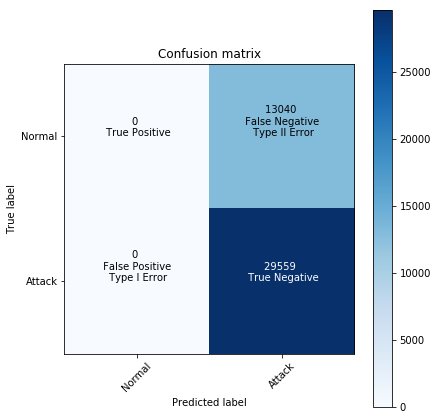

In [22]:
plot(actual_value = df.loc[:,'Actual'].values.astype(int),
     pred_value = df.loc[:,'Prediction'].values.astype(int))